
# CNN-KCL: Automatic Myocardium Diagnosis using Convolutional Neural Network Combined with K-means Clustering

In [4]:
def clust_func(input_data_x,input_data_y,k):
    import numpy as np
    from sklearn.cluster import KMeans

    print('Start Clustering.............!')
    normals=[]
    sicks=[]
    for i in range(len(input_data_y)):
        if input_data_y[i]==0:
            normals.append(input_data_x[i])
        else:
            sicks.append(input_data_x[i])

    normals=np.array(normals)
    sicks=np.array(sicks)

    model=KMeans(n_clusters=k)   
    y_n=model.fit_predict(normals)  
    y_s=model.fit_predict(sicks)

    y_s2=[]
    for item in y_s:
        y_s2.append(item+k)

    y_n=list(y_n)
    y_n.extend(y_s2)
    y=np.array(y_n)

    normals=list(normals)
    sicks=list(sicks)
    normals.extend(sicks)
    x=np.array(normals)

    return x,y

In [5]:
def net_plot(net_histories,n_epoch):
    import numpy as np
    import matplotlib.pyplot as plt
  
    losses=[]
    val_losses=[]
    accuracies=[]
    val_accuracies=[]
    fold_number = 5

    for item in net_histories:
        
        history=item.history
        loss=history['loss']
        val_loss=history['val_loss']
        accuracy=history['accuracy']
        val_accuracy=history['val_accuracy']
        
        losses.append(loss)
        val_losses.append(val_loss)
        accuracies.append(accuracy)
        val_accuracies.append(val_accuracy)

    losses2=np.zeros((1,n_epoch))
    val_losses2=np.zeros((1,n_epoch))
    accuracies2=np.zeros((1,n_epoch))
    val_accuracies2=np.zeros((1,n_epoch))

    for i in losses:
        losses2+=i

    for i in val_losses:
        val_losses2+=i
    
    for i in accuracies:
        accuracies2+=i
    
    for i in val_accuracies:
        val_accuracies2+=i

    # 10 is number of folds
    # 5 is number of folds
    losses2=(losses2/fold_number).flatten()
    accuracies2=(accuracies2/fold_number).flatten()
    val_losses2=(val_losses2/fold_number).flatten()
    val_accuracies2=(val_accuracies2/fold_number).flatten()

    plt.figure('Accuracy Diagram',dpi=600)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(accuracies2,color='black')
    plt.plot(val_accuracies2,color='green')
    plt.legend(['Train Data','Validation Data'])
    plt.savefig('Accuracy Diagram.jpg')

    plt.figure('Loss Diagram',dpi=600)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(losses2,color='black')
    plt.plot(val_losses2,color='green')
    plt.legend(['Train Data','Validation Data'])
    plt.savefig('Loss Diagram.jpg')

In [6]:
def deep_cnn(input_data_x,input_data_y,k):

    import datetime
    from sklearn.metrics import ( auc, classification_report,
                                confusion_matrix, roc_curve)
    from sklearn.model_selection import KFold, train_test_split
    from keras.layers import Conv1D,Dense, Dropout, Flatten
    from keras.losses import binary_crossentropy
    from keras.models import Sequential
    from keras.optimizers import Adam
    from keras.utils import np_utils
    from keras.callbacks import CSVLogger

    print('Start Deep Learning............!')

    lst_loss=[]
    lst_acc=[]
    lst_reports=[]
    lst_auc=[]
    lst_matrix=[]
    lst_times=[]
    lst_history=[]
    fold_number=5
    fold_iter=1
    n_epoch=30

    k_fold=KFold(n_splits=fold_number,shuffle=True,random_state=None)
    for train,test in k_fold.split(input_data_x,input_data_y):

        x_train=input_data_x[train]
        x_test=input_data_x[test]
        y_train=input_data_y[train]
        y_test=input_data_y[test]

        x_train,y_train=clust_func(x_train,y_train,k)
        x_test,y_test=clust_func(x_test,y_test,k)

        x_train=x_train.reshape((x_train.shape[0],100,100))
        x_test=x_test.reshape((x_test.shape[0],100,100))

        x_train,x_valid,y_train,y_valid=train_test_split(x_train,y_train,test_size=0.3,random_state=None)

        print(f'train: {x_train.shape}  {y_train.shape}')
        print(f'test: {x_test.shape}  {y_test.shape}')
        print(f'valid: {x_test.shape}  {y_valid.shape}')

        call_back=CSVLogger(f'logger_fold{fold_number}.log')

        y_train=np_utils.to_categorical(y_train)
        y_test=np_utils.to_categorical(y_test)
        y_valid=np_utils.to_categorical(y_valid)

        # CNN Architecture
        model=Sequential()
        model.add(Conv1D(32,3,padding='same',activation='relu',strides=2,input_shape=(100,100)))
        model.add(Conv1D(64,3,padding='same',activation='relu',strides=2))
        model.add(Conv1D(128,3,padding='same',activation='relu',strides=2))
        model.add(Conv1D(256,3,padding='same',activation='relu',strides=1))
        model.add(Conv1D(256,3,padding='same',activation='relu',strides=1))
        model.add(Conv1D(256,3,padding='same',activation='relu',strides=1))
        model.add(Flatten())
        model.add(Dense(256,activation='relu'))
        model.add(Dense(128,activation='relu'))
        model.add(Dense(64,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(k*2,activation='sigmoid'))

        model.compile(optimizer=Adam(),loss=binary_crossentropy,metrics=['accuracy'])
            
        start=datetime.datetime.now()
        net_history=model.fit(x_train, y_train, batch_size=256, epochs=n_epoch,validation_data=(x_valid,y_valid),callbacks=[call_back])
        end=datetime.datetime.now()
        training_time=end-start

        model.save(f'CNN_fold{fold_number}.h5')

        test_loss, test_acc=model.evaluate(x_test,y_test)

        predicts=model.predict(x_test)
        predicts=predicts.argmax(axis=1)
        actuals=y_test.argmax(axis=1)

        fpr, tpr, thresholds = roc_curve(actuals, predicts, pos_label=1)
        a=auc(fpr,tpr)
        r=classification_report(actuals,predicts)
        c=confusion_matrix(actuals,predicts)

        lst_history.append(net_history)
        lst_times.append(training_time)
        lst_acc.append(test_acc)
        lst_loss.append(test_loss)
        lst_auc.append(a)
        lst_reports.append(r)
        lst_matrix.append(c)

        fold_iter+=1
        
    # plot loss and accuracy diagrams
    net_plot(lst_history,n_epoch)

    path=f'CNN_Kmeans_Results.txt' 
    f1=open(path,'a')
    f1.write('\nAccuracies: '+str(lst_acc)+'\nLosses: '+str(lst_loss))
    f1.write('\n\nMetrics for all Folds: \n\n')
    for i in range(len(lst_reports)):
        f1.write(str(lst_reports[i]))
        f1.write('\n\nTraining Time: '+str(lst_times[i])+'\nAUC: '+str(lst_auc[i]))
        f1.write('\n\nConfusion Matrix: \n'+str(lst_matrix[i])+'\n\n__________________________________________________________\n')
    f1.close()

In [2]:
def read_data():
    import numpy as np
    import cv2
    from skimage.io import imread
    import glob
    import os

    normals=[]
    #main_path='/kaggle/input/myocarditis-dataset/Normal/'
    main_path='Normal/'
    main_folders=next(os.walk(main_path))[1]
    for i in main_folders:
        path=main_path+i+'/'
        folders=next(os.walk(path))[1]
        for x in folders:
            new_path=path+x+'/'
            data=glob.glob(new_path+'*.jpg')
            if len(data)<1:
                indent_folders=next(os.walk(new_path))[1]
                for y in indent_folders:
                    new_path=new_path+y+'/'
                    data=glob.glob(new_path+'*.jpg')
            normals.extend(data)

    #read sicks files
    sicks=[]
    #main_path='/kaggle/input/myocarditis-dataset/Sick/'
    main_path='Sick/'
    main_folders=next(os.walk(main_path))[1]
    for i in main_folders:
        path=main_path+i+'/'
        folders=next(os.walk(path))[1]
        for x in folders:
            new_path=path+x+'/'
            data=glob.glob(new_path+'*.jpg')
            if len(data)<1:
                indent_folders=next(os.walk(new_path))[1]
                for y in indent_folders:
                    new_path=new_path+y+'/'
                    data=glob.glob(new_path+'*.jpg')
            sicks.extend(data)
    
    #load normal files
    labels_n=[]
    train_data_n=[]
    for id_normal in normals:
        img=imread(id_normal)
        img=cv2.resize(img,(100,100))
        # img=img.astype('float32')
        img=img.flatten()
        train_data_n.append(img)
        labels_n.append(0)

    #load sick files
    labels_s=[]
    train_data_s=[]
    for id_sick in sicks:
        img=imread(id_sick)
        img=cv2.resize(img,(100,100))
        # img=img.astype('float32')
        img=img.flatten()
        train_data_s.append(img)
        labels_s.append(1)

    train_data_n.extend(train_data_s)
    labels_n.extend(labels_s)

    x_data=np.array(train_data_n)
    y_data=np.array(labels_n)

    return x_data, y_data

In [3]:
x_data, y_data = read_data()

Start Deep Learning............!
Start Clustering.............!
Start Clustering.............!
train: (23179, 100, 100)  (23179,)
test: (8279, 100, 100)  (8279,)
valid: (8279, 100, 100)  (9935,)
Epoch 1/30
91/91 [==============================] - 4s 20ms/step - loss: 0.4880 - accuracy: 0.5968 - val_loss: 0.2353 - val_accuracy: 0.8083
Epoch 2/30
91/91 [==============================] - 1s 15ms/step - loss: 0.2159 - accuracy: 0.8349 - val_loss: 0.1547 - val_accuracy: 0.8644
Epoch 3/30
91/91 [==============================] - 1s 16ms/step - loss: 0.1424 - accuracy: 0.8872 - val_loss: 0.1564 - val_accuracy: 0.8594
Epoch 4/30
91/91 [==============================] - 1s 16ms/step - loss: 0.1181 - accuracy: 0.9070 - val_loss: 0.1327 - val_accuracy: 0.8941
Epoch 5/30
91/91 [==============================] - 1s 16ms/step - loss: 0.0976 - accuracy: 0.9202 - val_loss: 0.1148 - val_accuracy: 0.9060
Epoch 6/30
91/91 [==============================] - 1s 16ms/step - loss: 0.0802 - accuracy: 0.9319 -

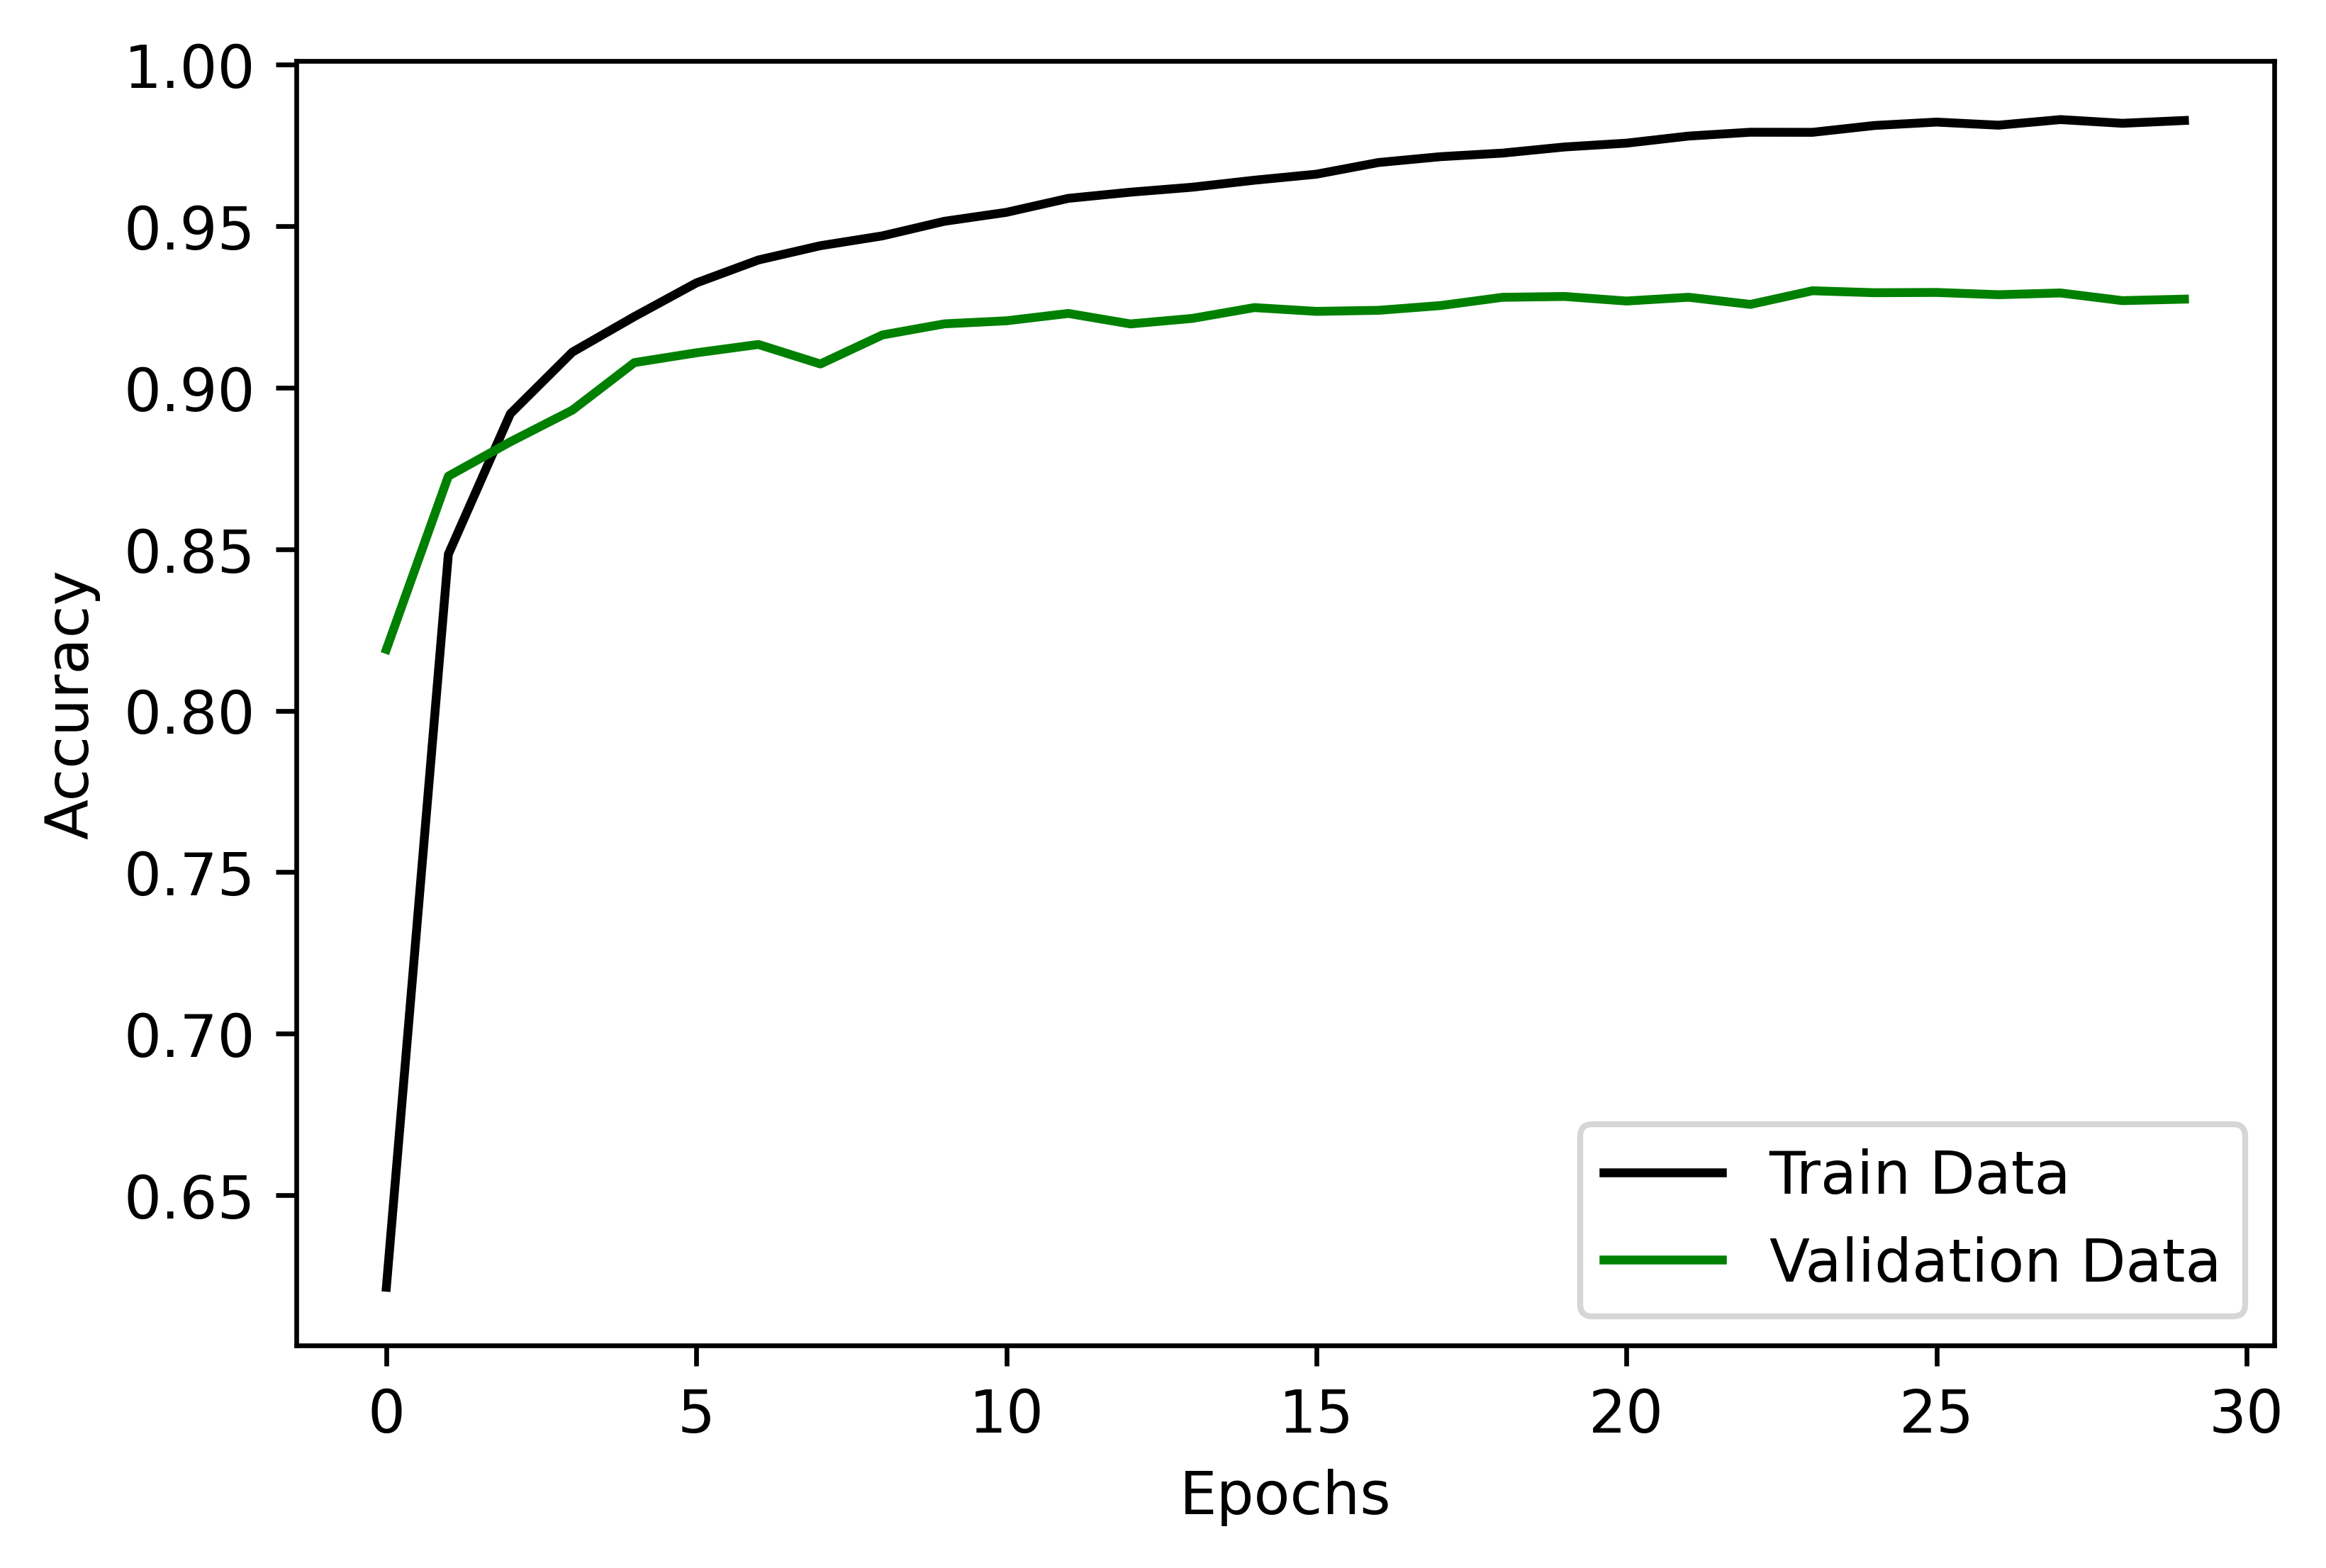

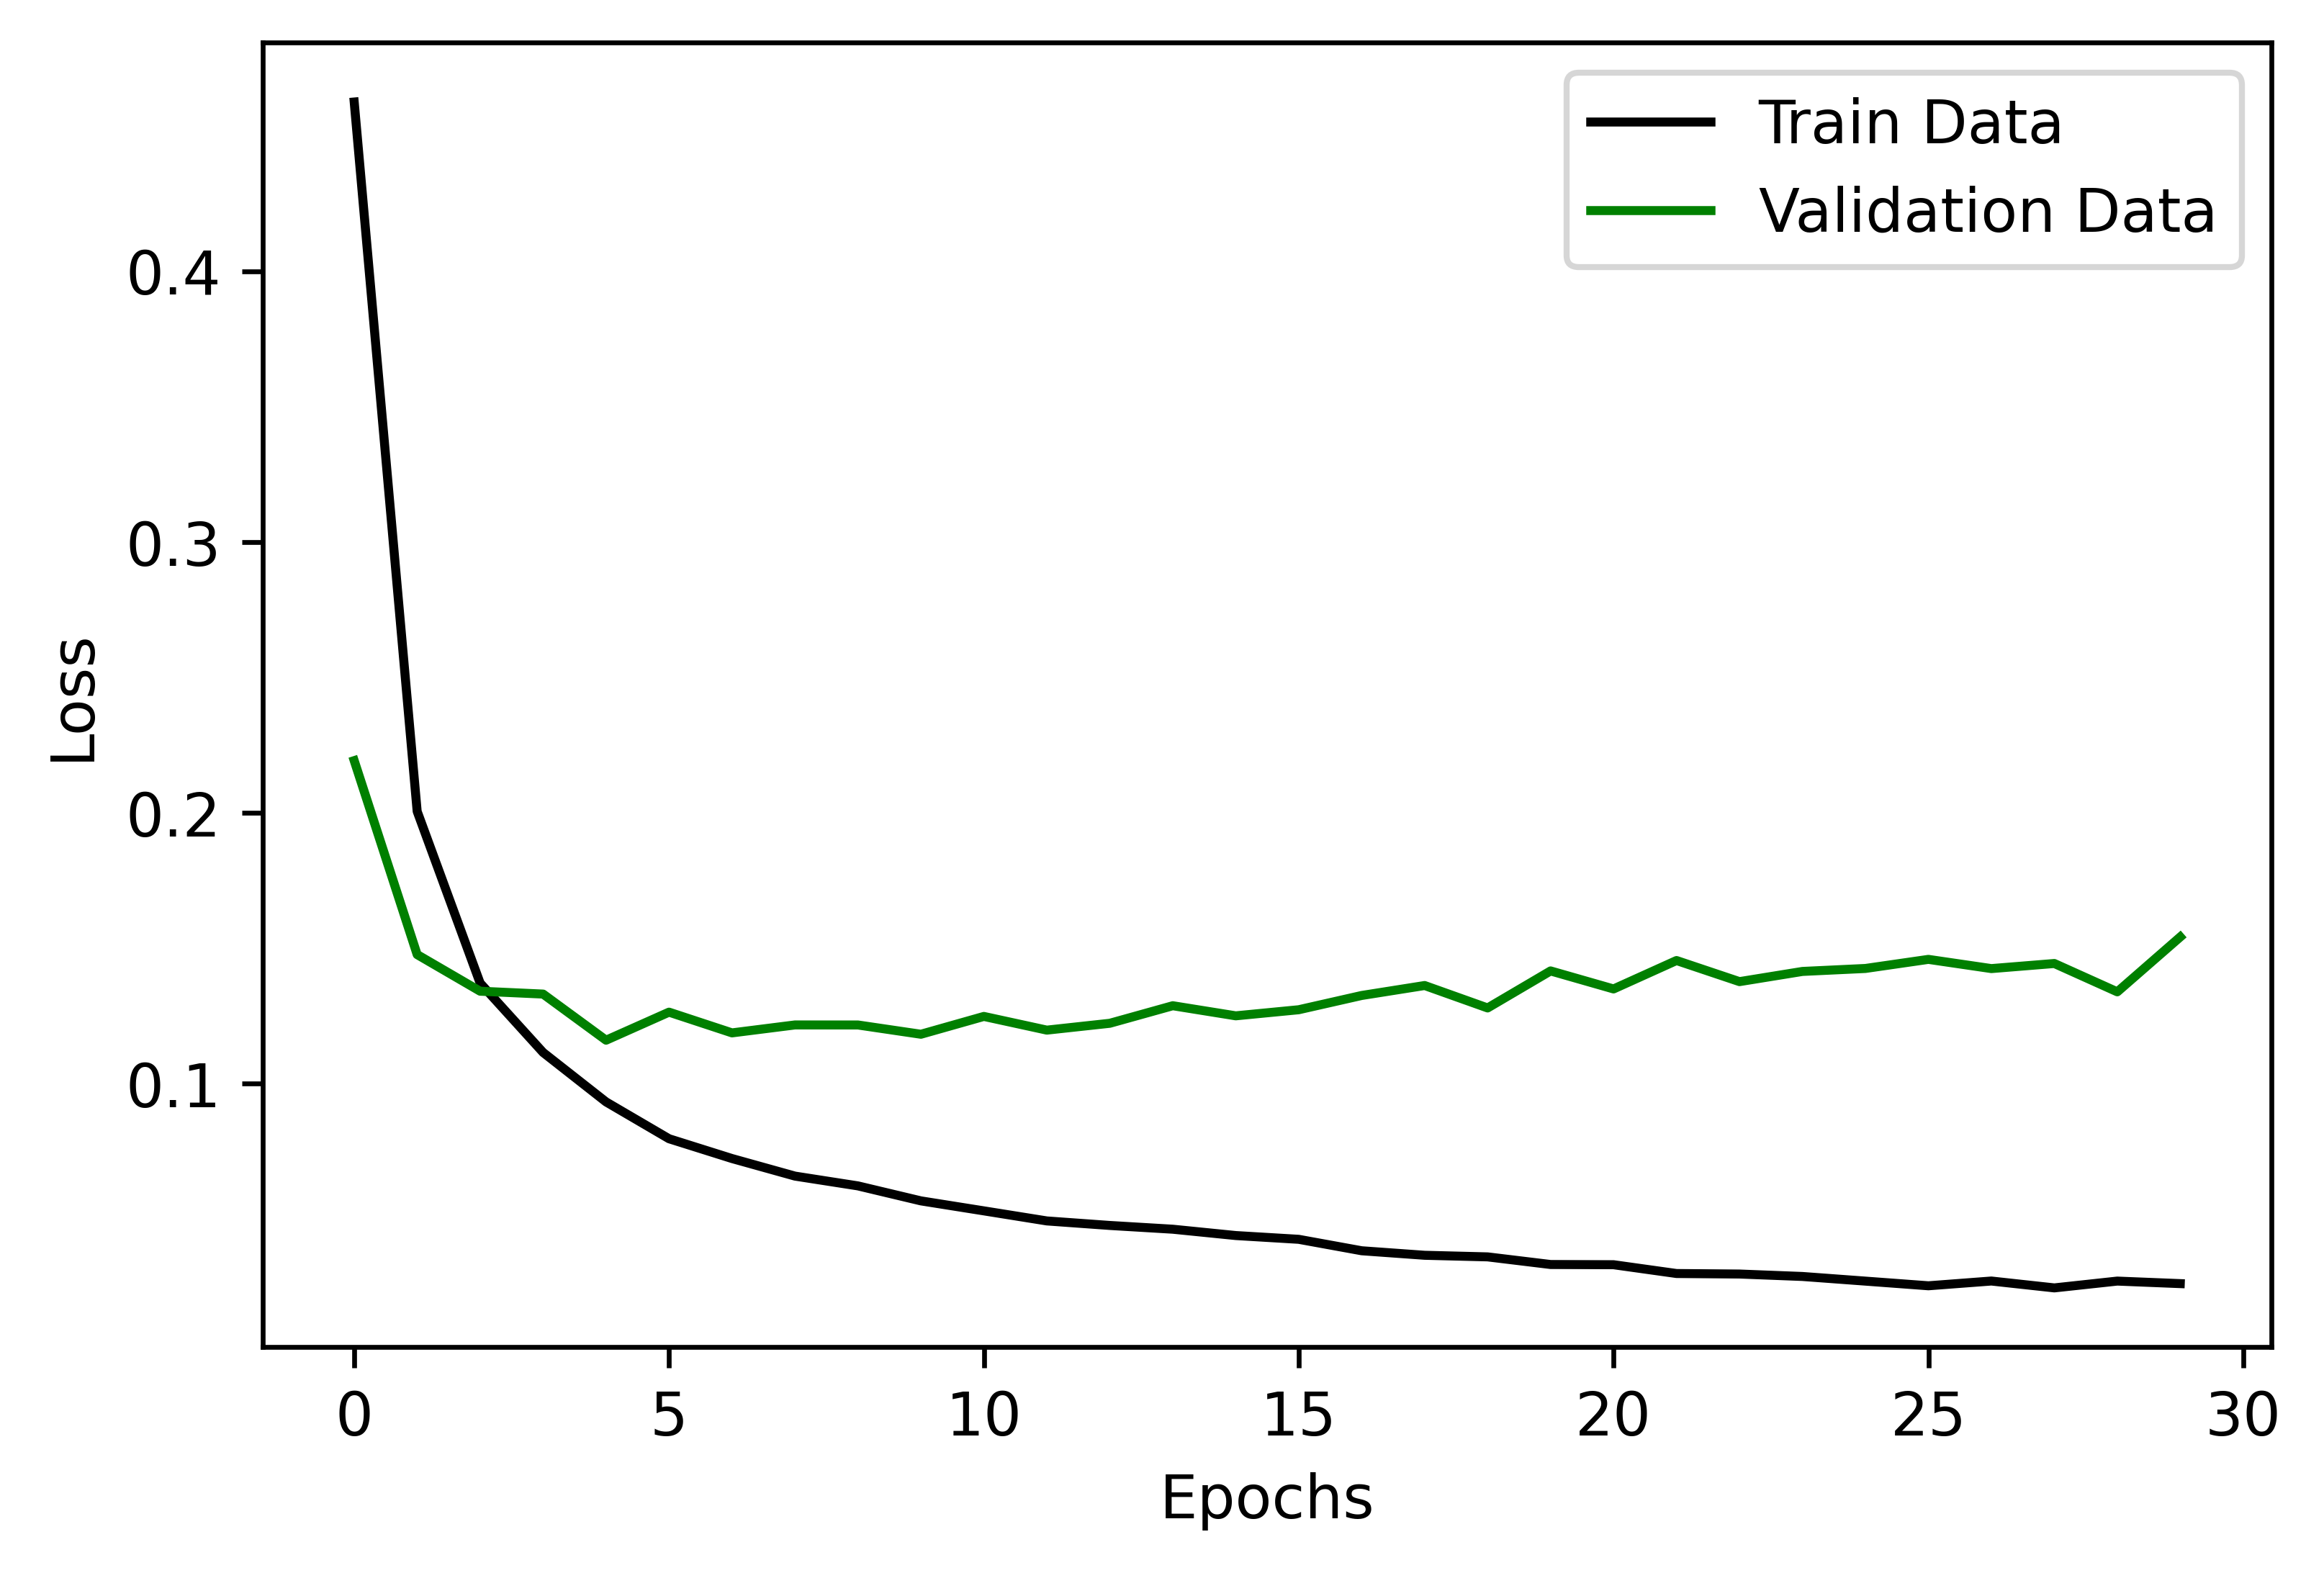

In [7]:
# calling deep learning method
deep_cnn(x_data, y_data, k=2)

import tensorflow as tf
tf.version.VERSION